In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
print("The train dataset has %d observations and %d features" % train.shape)
print("The test dataset has %d observations and %d features" % test.shape)
cat_features = train.select_dtypes(include=["object"]).columns
num_features = train.select_dtypes(exclude=['object']).columns
print("# of Numerical features is " + str(len(num_features)) + " and # of categorical features is " + str(len(cat_features)))

The train dataset has 1460 observations and 81 features
The test dataset has 1459 observations and 80 features
# of Numerical features is 38 and # of categorical features is 43


In [6]:
# Check the label: Average sale price is 181k, with the highest value of 755k and the lowest value of 79k
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Check out numeric features

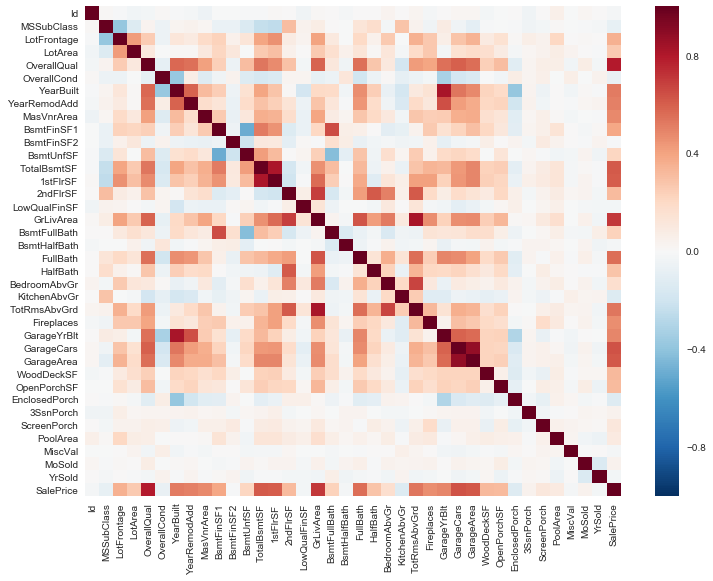

In [7]:
# Check numeric feature correlations using Heatmap
# Correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1.0, square=False);

It seems that the following numeric features are highly related to sale price:
OverallQual, TotalBsmtSF, 1stFlrSF, GrLivArea, Fullbath, TotRmsAbvGrd, GarageCars,GarageArea.
Create a zoomed heatmap to take a loser look at those vars.

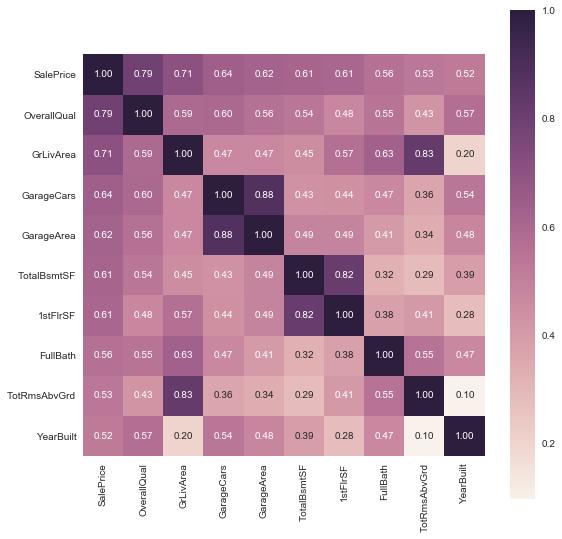

In [8]:
# Saleprice correlation matrix (zoomed heat map)
k=10
cols=corrmat['SalePrice'].nlargest(k).index
cm=np.corrcoef(train[cols].values.T)
plt.figure(figsize=(9,9))
sns.heatmap(cm,cbar=True,annot= True,square=True,fmt='.2f',annot_kws={'size':10},xticklabels=cols.values,yticklabels=cols.values)

Three pairs of features have the colinearity issue: GarageCars vs GarageArea, TotalBsmtSF vs 1stFlrSF, and GrLivArea vs TotRmsAbvGrd; Those are pretty analogous features. I would keep GarageCars, GrLivArea, and TotalBsmtSF since their correlation to SalePrice is slightly higher 

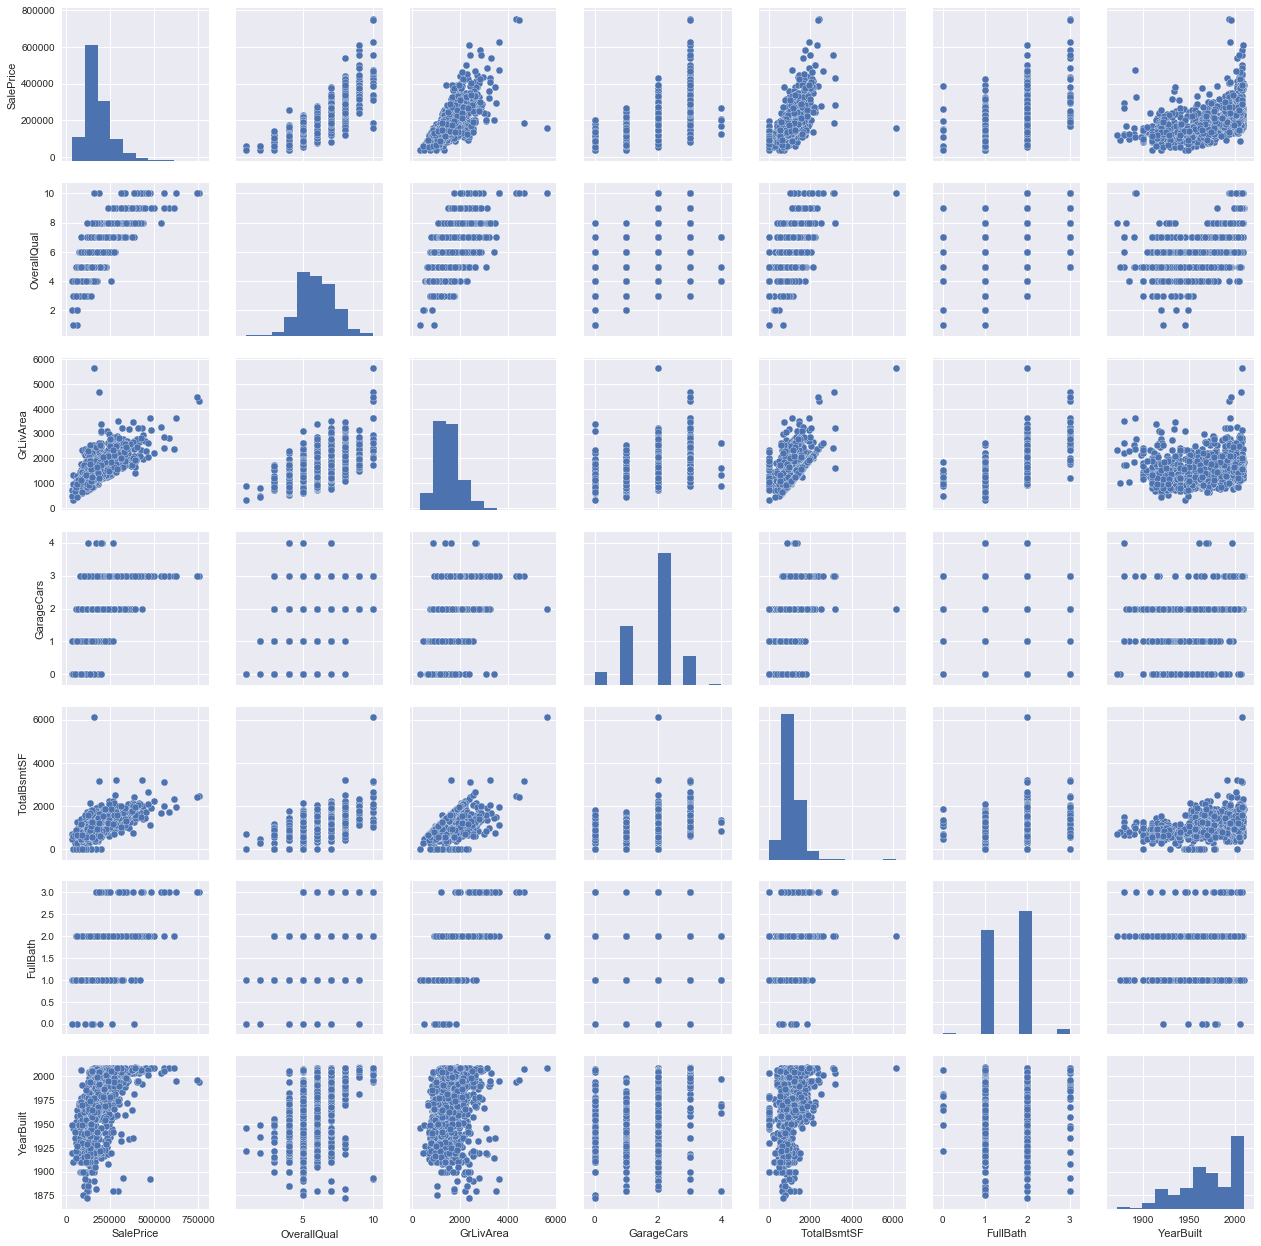

In [9]:
# Check covariants via pairplot
important_nums =["SalePrice","OverallQual","GrLivArea","GarageCars","TotalBsmtSF", "FullBath","YearBuilt"]
sns.pairplot(train[important_nums])

A couple of findings:

1) None of the features closes to normal distribution. Transformation is needed;

2) All features are positively correlated to sale price;

3) Some outliers can be found. For example, the dots representing extra large living space in both GrLivArea and TotalBsmtSF

## Check out categorical features

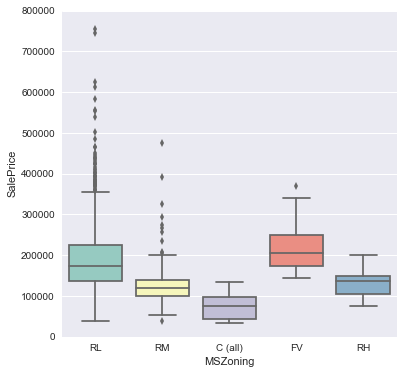

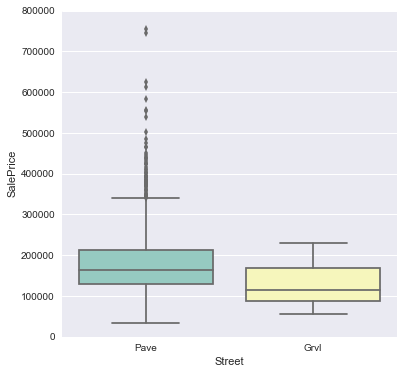

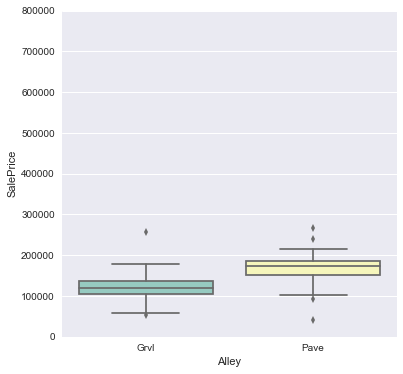

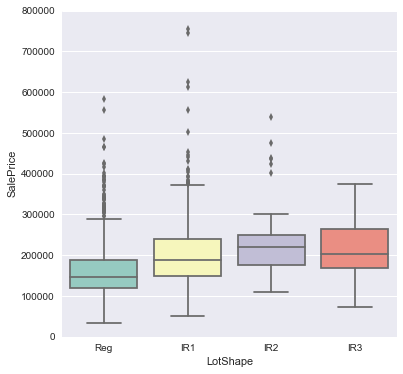

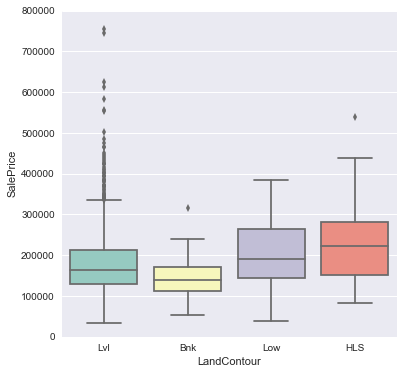

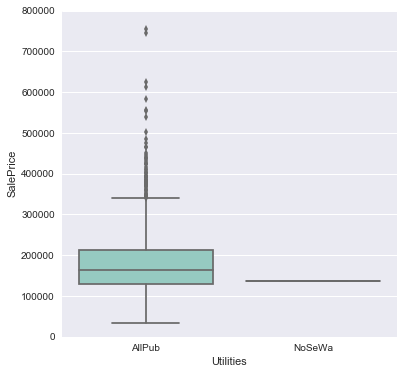

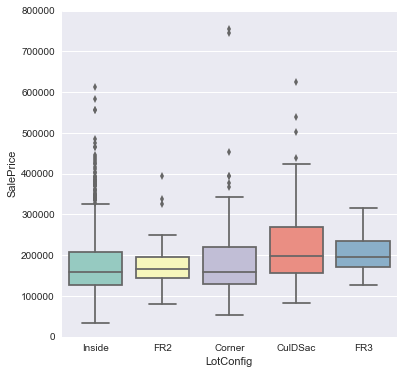

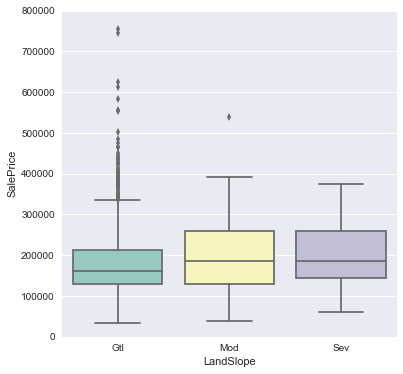

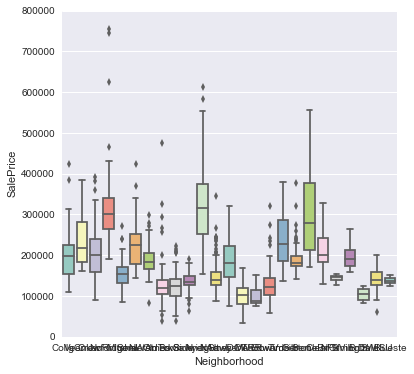

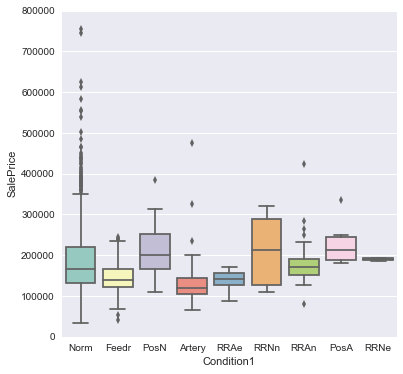

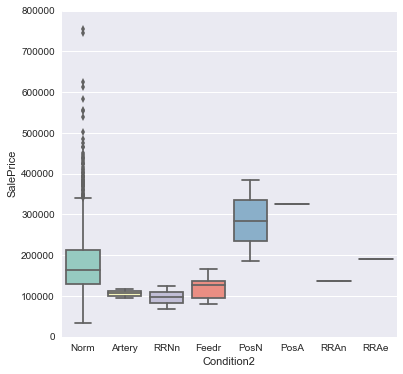

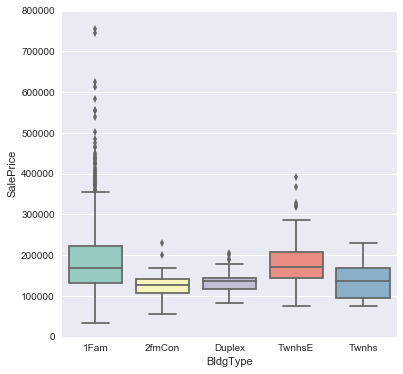

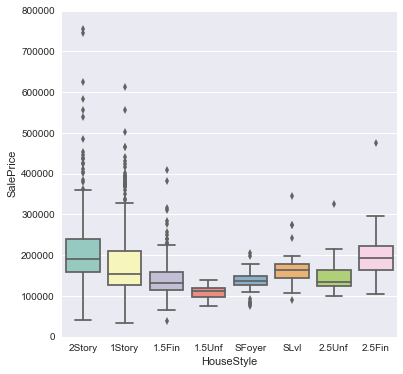

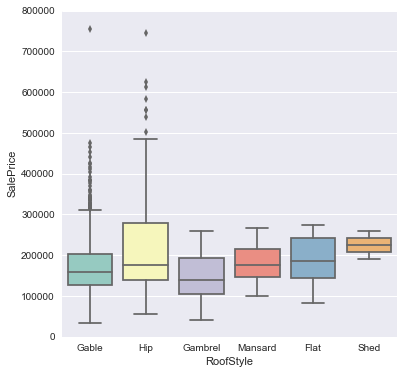

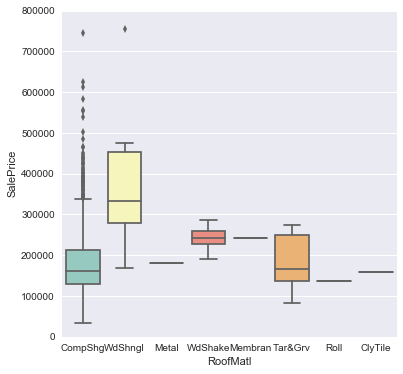

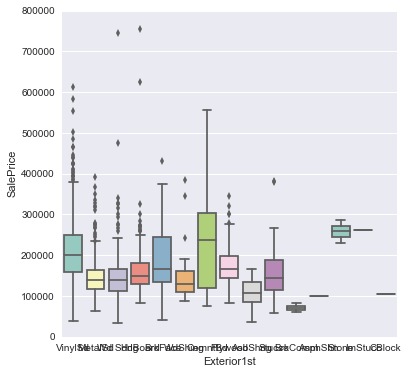

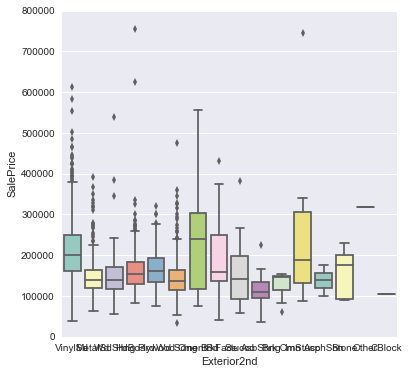

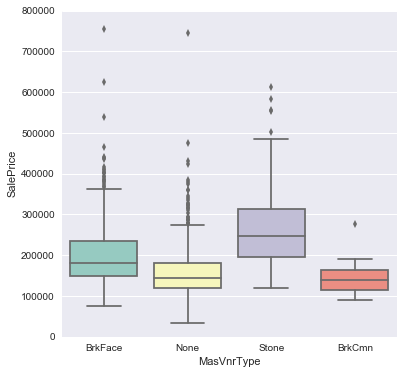

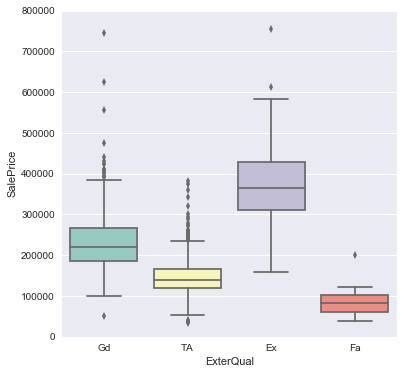

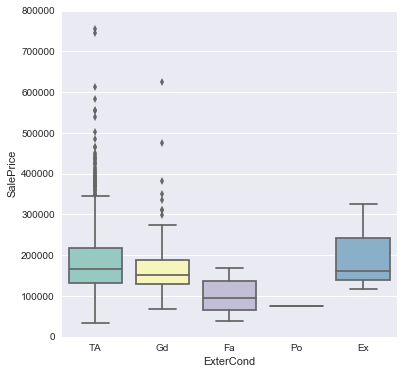

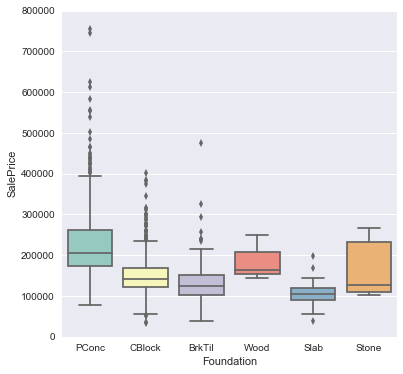

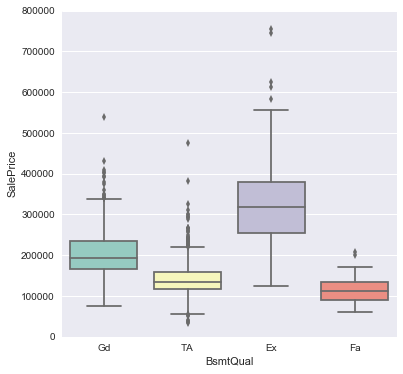

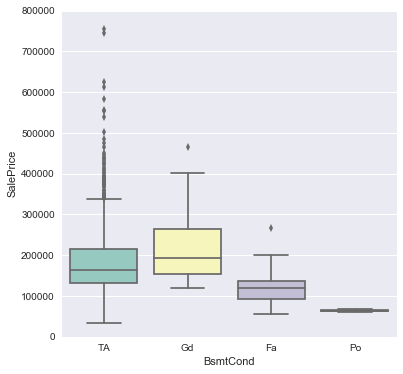

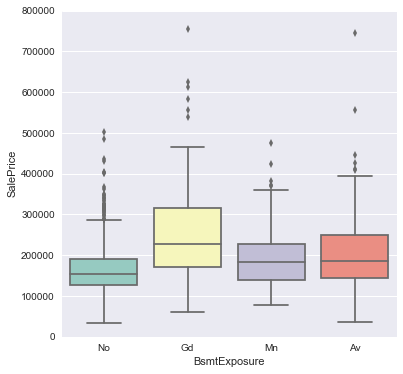

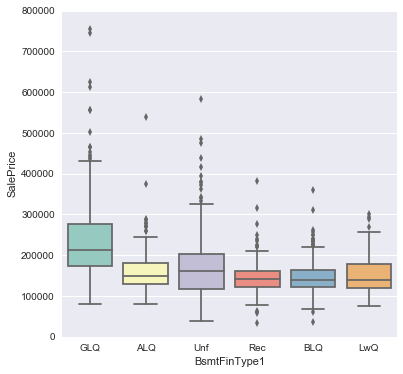

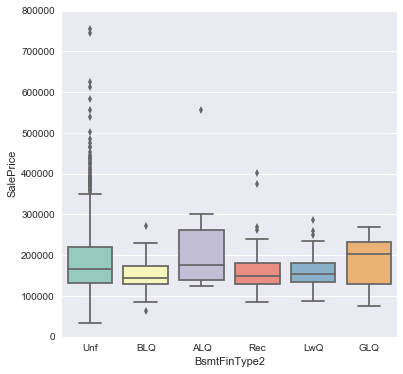

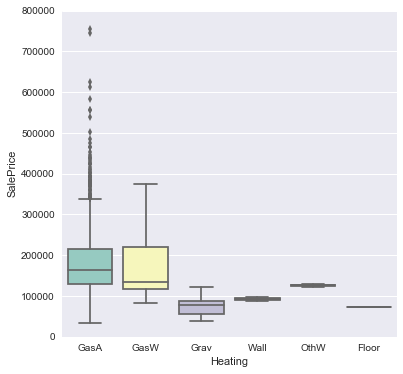

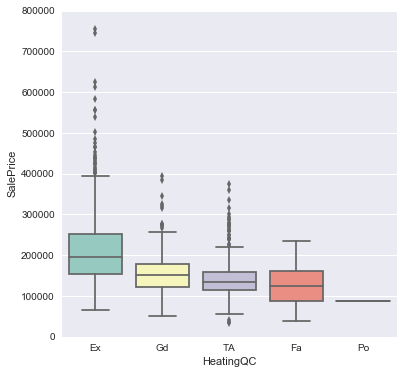

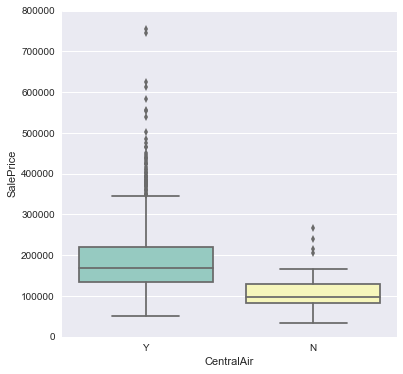

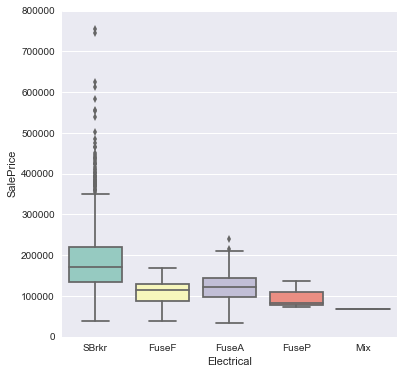

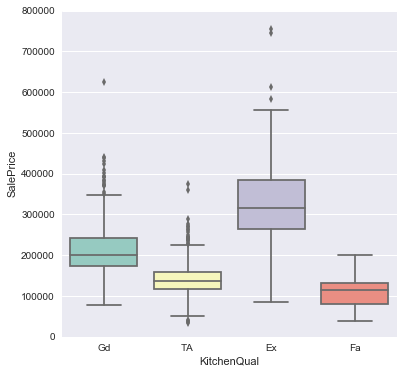

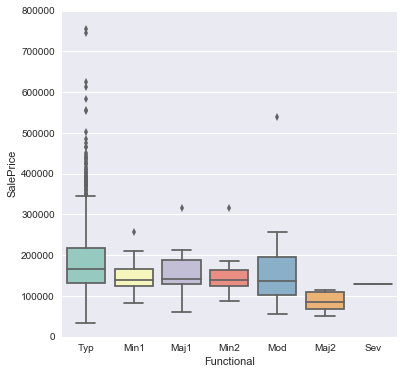

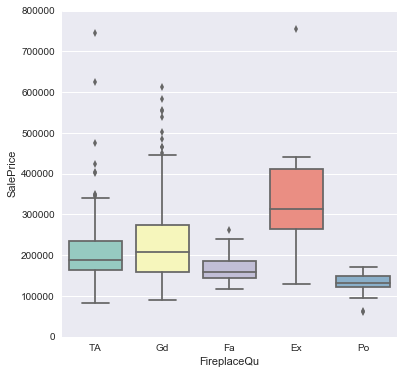

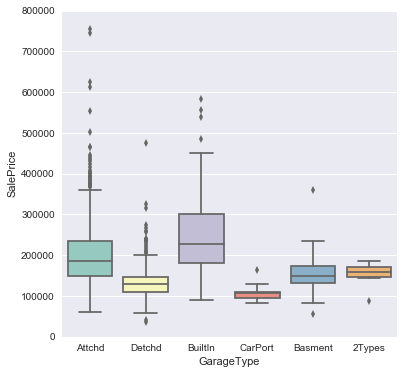

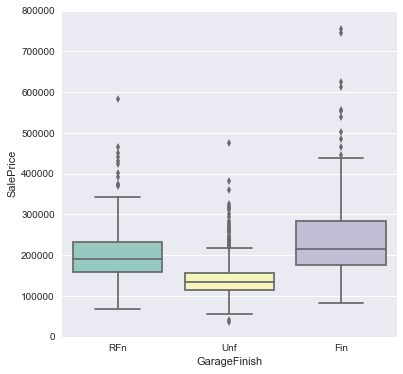

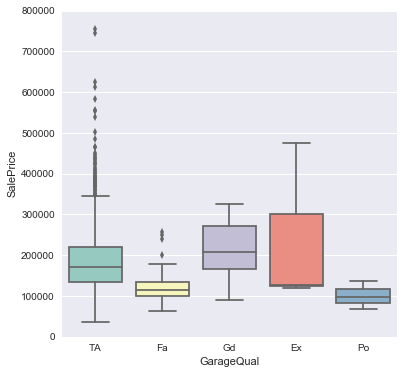

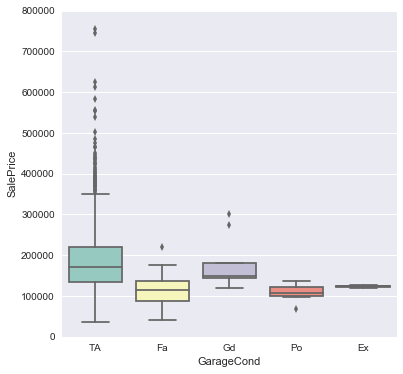

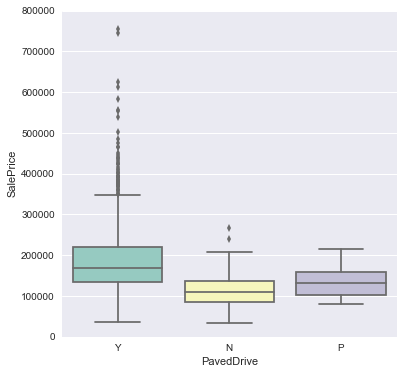

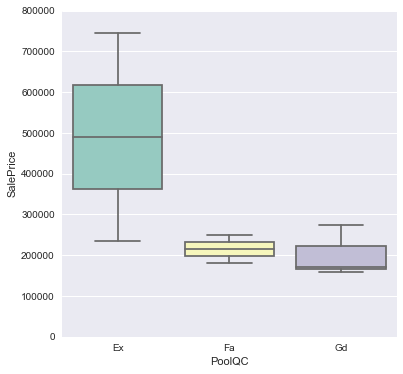

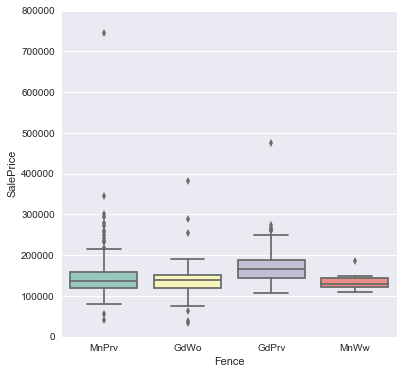

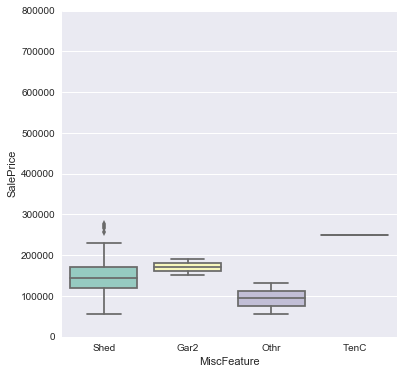

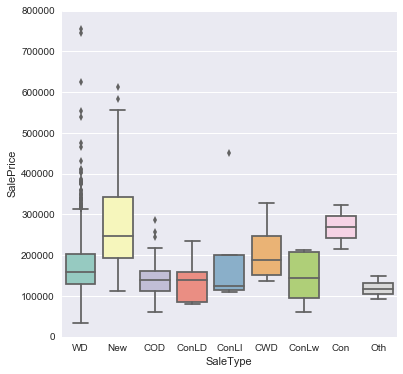

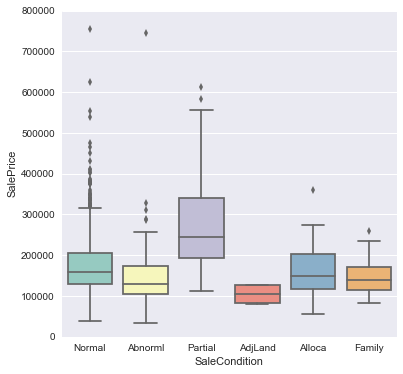

In [10]:
for feature in cat_features:
    f,ax=plt.subplots(figsize=(6,6))
    ax = sns.boxplot(x=feature, y="SalePrice",data=train,palette="Set3")
    ax.axis(ymin=0, ymax=800000)

Some categories seem to more diverse with respect to SalePrice than others.The following categorical vars are correlated to sale price, based on eyeball check on box plots:

Neighborhood, Condition1, condition2, bldgType,HouseStyle, RoofMatl, Exterior1st,Exteior2nd,ExterQual,ExterCond, Foundation,BsmtQual,BsmtCond, BsmtFinType1,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,SaleType,SaleCondition

## Remove outliers

In [11]:
# Create list of potential outliers to examine
potentials = pd.DataFrame()

# For important numeric features, find the data points with extreme high or low values using Tukey's method
for feature in important_nums:
    Q1 = np.nanpercentile(train[feature], 25)
    Q3 = np.nanpercentile(train[feature], 75)
    IQR = (Q3-Q1)   
    # Check how far each obs is from either Q1 or Q3, normalized by IQR
    distance = [(Q1-x)/IQR if x < Q1 else (x-Q3)/IQR if x > Q3 else 0 for x in train[feature]]
    potentials = potentials.append(train.loc[np.array(distance) >= 3])

# choose the outliers that have appeared twice or more in this list
outliers = potentials.loc[potentials.duplicated(keep=False)]
print(outliers[important_nums])

      SalePrice  OverallQual  GrLivArea  GarageCars  TotalBsmtSF  FullBath  \
440      555000           10       2402           3         3094         2   
691      755000           10       4316           3         2444         3   
1182     745000           10       4476           3         2396         3   
523      184750           10       4676           3         3138         3   
691      755000           10       4316           3         2444         3   
1182     745000           10       4476           3         2396         3   
1298     160000           10       5642           2         6110         2   
440      555000           10       2402           3         3094         2   
523      184750           10       4676           3         3138         3   
1298     160000           10       5642           2         6110         2   

      YearBuilt  
440        2008  
691        1994  
1182       1996  
523        2007  
691        1994  
1182       1996  
1298       2008

In [12]:
# Combine the Tukey test and eyeball test to determine what to remove
# 1298, 523, 691, 440 appear twice. 1298 and 523 have more extrme values than the other two, so drop them first and keep 691 and 440 for now.
print(train.shape)
train = train.drop(train[train.index==1298].index)
train = train.drop(train[train.index==523].index)
print(train.shape)

(1460, 81)
(1458, 81)


## Check out the label

Skewness of the label is 1.881296


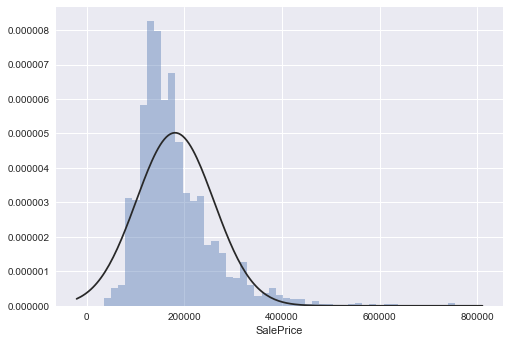

In [13]:
# The distribution of sale price deviates from the normal distribution and positively skewed
sns.distplot(train.SalePrice, fit=norm,kde = False)
print("Skewness of the label is %f" % train['SalePrice'].skew())

## Transform the label

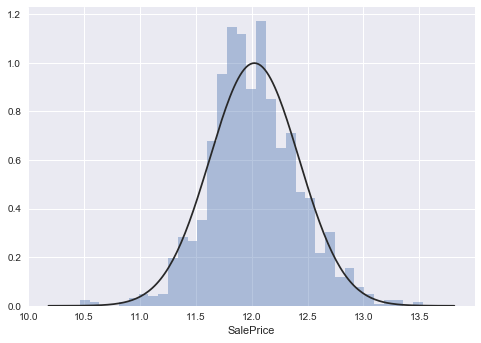

In [14]:
# Log transform the label
saleprice_transformed = np.log(train.SalePrice)
sns.distplot(saleprice_transformed,fit=norm,kde = False)
fig= plt.figure()

## Handle missing data

In [15]:
# Merge train and test df
all= pd.concat([train,test],keys=("train","test"))
all =all.drop("SalePrice",axis=1)
print(all.shape)

(2917, 80)


In [16]:
# Check missing data
total = all.isnull().sum().sort_values(ascending=False)
pct = (all.isnull().sum()/all.isnull().count()).sort_values(ascending=False)
NAs = pd.concat([total, pct], axis=1, keys=['Total', 'Percent'])
NAs = NAs[NAs['Total']>=1]
NAs

,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageQual,159,0.054508
GarageFinish,159,0.054508
GarageYrBlt,159,0.054508
GarageCond,159,0.054508


In [17]:
for col in NAs.index:
    print(all[col].value_counts())

Ex    4
Gd    3
Fa    2
Name: PoolQC, dtype: int64
Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64
Grvl    120
Pave     78
Name: Alley, dtype: int64
MnPrv    329
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64
Gd    742
TA    592
Fa     74
Po     46
Ex     43
Name: FireplaceQu, dtype: int64
60.0     276
80.0     137
70.0     133
50.0     117
75.0     105
65.0      93
85.0      76
21.0      50
24.0      49
63.0      47
78.0      46
90.0      46
68.0      44
64.0      43
74.0      39
72.0      39
73.0      33
62.0      31
52.0      28
100.0     28
82.0      28
79.0      28
51.0      27
59.0      27
57.0      26
66.0      26
76.0      25
53.0      24
55.0      24
43.0      23
        ... 
122.0      2
116.0      2
149.0      2
150.0      2
174.0      2
155.0      1
123.0      1
135.0      1
111.0      1
117.0      1
131.0      1
200.0      1
22.0       1
136.0      1
28.0       1
31.0       1
25.0       1
313.0      1
133.0      1
126.0      1


In [18]:
# Impute NAs
   
# no alley
all["Alley"].fillna("None", inplace=True)

# no basement
all["BsmtCond"].fillna("None", inplace=True)
all["BsmtExposure"].fillna("None", inplace=True)
all["BsmtFinSF1"].fillna(0, inplace=True)               
all["BsmtFinSF2"].fillna(0, inplace=True)               
all["BsmtUnfSF"].fillna(0, inplace=True)                
all["TotalBsmtSF"].fillna(0, inplace=True)
all["BsmtFinType1"].fillna("None", inplace=True)
all["BsmtFinType2"].fillna("None", inplace=True)
all["BsmtFullBath"].fillna(0, inplace=True)
all["BsmtHalfBath"].fillna(0, inplace=True)
all["BsmtQual"].fillna("None", inplace=True)

# no fence
all["Fence"].fillna("None", inplace=True)

# no fireplace
all["FireplaceQu"].fillna("None", inplace=True)

# no garage
all["GarageArea"].fillna(0, inplace=True)
all["GarageCars"].fillna(0, inplace=True)
all["GarageCond"].fillna("None", inplace=True)
all["GarageFinish"].fillna("None", inplace=True)
all["GarageQual"].fillna("None", inplace=True)
all["GarageType"].fillna("None", inplace=True)
all["GarageYrBlt"].fillna("None", inplace=True)

# lot frontage (no explanation for NA values, perhaps no frontage)
all["LotFrontage"].fillna(0, inplace=True)

# Masonry veneer (no explanation for NA values, perhaps no masonry veneer)
all["MasVnrArea"].fillna(0, inplace=True)
all["MasVnrType"].fillna("None", inplace=True)

# no misc features
all["MiscFeature"].fillna("None", inplace=True)

# most common value
all["MSZoning"].fillna("RL", inplace=True)

# "typical" kitchen
all["KitchenQual"].fillna("TA", inplace=True)

# most common electrical system
all["Electrical"].fillna("SBrkr", inplace=True)

# fill with typical functionality
all["Functional"].fillna("Typ", inplace=True)

# most common
all["Utilities"].fillna("AllPub", inplace=True)

# description says NA = no pool, but there are entries with PoolArea >0 and PoolQC = NA. Fill the ones with values with average condition
all.loc[(all['PoolQC'].isnull()) & (all['PoolArea']==0), 'PoolQC' ] = 'None'
all.loc[(all['PoolQC'].isnull()) & (all['PoolArea']>0), 'PoolQC' ] = 'TA'

# classify missing SaleType as other
all["SaleType"].fillna("Other", inplace=True)

# one missing in test; set to other
all["Exterior1st"].fillna("Other", inplace=True)
all["Exterior2nd"].fillna("Other", inplace=True)


# double check if there is still missing values
all_NAs = all.isnull().sum()
all_NAs = all_NAs[all_NAs>0]
all_NAs.index

Index([], dtype='object')

## Feature Engineering

In [19]:
# Differentiate numerical features and categorical features
cat_features = all.select_dtypes(include=["object"]).columns
num_features = all.select_dtypes(exclude=['object']).columns
all_num = all[num_features]
all_cat = all[cat_features]
print(all_num.shape)
print(all_cat.shape)

(2917, 36)
(2917, 44)


In [20]:
# Log transform of the skewed numerical features to lessen impact of outliers
skewed_features = all[num_features].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_features = skewed_features[skewed_features > 0.50]
skewed_features = skewed_features.index
print("number of skewed features is "+ str(len(skewed_features)))
all_num[skewed_features] = np.log1p(all_num[skewed_features])

number of skewed features is 25


In [21]:
# Polynomials on the most important numeric features
def quadratic(df,feature):
    df[feature+'2'] = df[feature]**2
    
def cubic(df,feature):
    df[feature+'3'] = df[feature]**3

In [22]:
cols =["OverallQual","GrLivArea","GarageCars","TotalBsmtSF", "FullBath"]
for feature in cols:
    quadratic(all_num,feature);
    cubic(all_num,feature);
all_num.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GrLivArea', 'HalfBath', 'Id', 'KitchenAbvGr', 'LotArea', 'LotFrontage',
       'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold',
       'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch',
       'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold', 'OverallQual2', 'OverallQual3', 'GrLivArea2',
       'GrLivArea3', 'GarageCars2', 'GarageCars3', 'TotalBsmtSF2',
       'TotalBsmtSF3', 'FullBath2', 'FullBath3'],
      dtype='object')

In [23]:
# Create dummy variable for categorical features
print("NAs for categorical features in train : " + str(all_cat.isnull().values.sum()))
all_cat = pd.get_dummies(all_cat)
print("Remaining NAs for categorical features in train : " + str(all_cat.isnull().values.sum()))

NAs for categorical features in train : 0
Remaining NAs for categorical features in train : 0


In [24]:
all_data = pd.concat([all_num,all_cat],axis=1)
all_data.shape

(2917, 418)

## Modelling

In [25]:
# merge categorical and numeric variables
idx = pd.IndexSlice
train_features = all_data.loc[idx[['train'],:],:]
test_features = all_data.loc[idx[['test'],:],:]
train_label = saleprice_transformed
print(train_features.shape)
print(test_features.shape)
print(len(train_label))

(1458, 418)
(1459, 418)
1458


In [26]:
# Double check no NAs in the train dataset
print(train_features.isnull().sum().max())

0


In [27]:
# Standardize the features
train_features = StandardScaler().fit_transform(train_features)
test_features = StandardScaler().fit_transform(test_features)

In [28]:
# Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_label, test_size=0.2, random_state=0)

In [29]:
# Define model evaluation function
def cv_rmse_train(estimator):
    rmse= np.sqrt(-cross_val_score(estimator, x_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
def cv_rmse_test(estimator):
    rmse= np.sqrt(-cross_val_score(estimator, x_test, y_test, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### Linear Regression with Ridge regularization (L2 penalty)

In [31]:
ridge = RidgeCV(alphas =[0.1,1,50,100,500,600]).fit(x_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 500.0


In [32]:
# Get a series of alphas centering around the best alpha
def get_params(center_params):
    new_params=[]
    for m in np.arange(0.8,1.2,0.05):
        new_params.append(round(center_params*m,4))
    return new_params

In [33]:
new_alphas = get_params(alpha)
print(new_alphas)
ridge = RidgeCV(alphas = new_alphas).fit(x_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

[400.0, 425.0, 450.0, 475.0, 500.0, 525.0, 550.0, 575.0]
Best alpha : 500.0


In [34]:
ridge_cv = RidgeCV(alphas = np.arange(0.1,701,100)).fit(x_train, y_train)
print("Best alpha :", ridge_cv.alpha_)
ridge = Ridge(alpha=500).fit(x_train, y_train)
print("Final ridge model:")
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(ridge).mean(),cv_rmse_train(ridge).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(ridge).mean(),cv_rmse_test(ridge).std()))

Best alpha : 500.1
Final ridge model:
RMSE (Training data): 0.1207 +/- 0.0100
RMSE (Validation data): 0.1420 +/- 0.0218


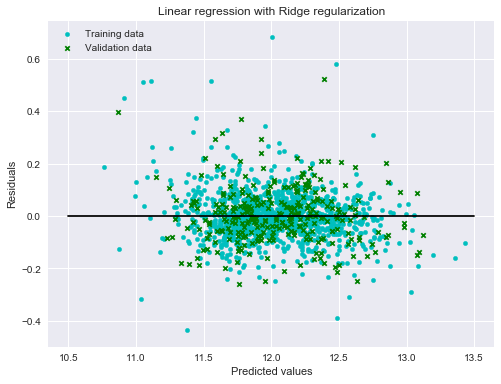

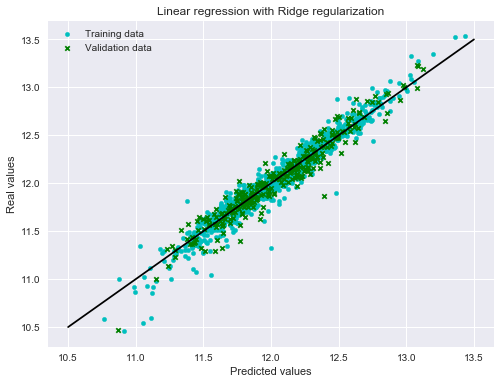

In [35]:
y_train_pred = ridge.predict(x_train)
y_test_pred = ridge.predict(x_test)

# Plot residence
plt.figure(figsize=(8,6))
plt.scatter(y_train_pred, y_train_pred - y_train, c = "c", marker = "o", s=20, label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "g", marker = "x", s=20, label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.plot([10.5,13.5],[0,0], color = "k")
plt.show()

# Plot predictions
plt.figure(figsize=(8,6))
plt.scatter(y_train_pred, y_train, c = "c", marker = "o", s=20, label = "Training data")
plt.scatter(y_test_pred, y_test, c = "g", marker = "x", s=20, label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "k")
plt.show()

### Linear Regression with Lasso regularization (L1 penalty)

In [36]:
# Fit Lasso model
lasso_cv = LassoCV(alphas =np.arange(0.001,1,0.001)).fit(x_train, y_train)
print("Best alpha :", lasso_cv.alpha_)

Best alpha : 0.004


In [37]:
lasso =Lasso(alpha=0.004).fit(x_train, y_train)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(lasso).mean(),cv_rmse_train(lasso).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(lasso).mean(),cv_rmse_test(lasso).std()))

RMSE (Training data): 0.1152 +/- 0.0128
RMSE (Validation data): 0.1258 +/- 0.0059


Lasso model: 118 features are picked and 300 features are dropped


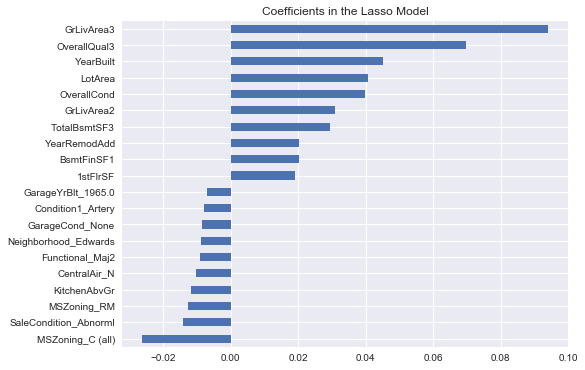

In [38]:
# Plot important coefficients
coefs = pd.Series(lasso.coef_,index=all_data.columns)
print("Lasso model: " + str(sum(coefs != 0))+" features are picked and " + str(sum(coefs == 0))+" features are dropped")
imp_coefs = pd.concat([coefs.sort_values().head(10),coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Lasso Model")

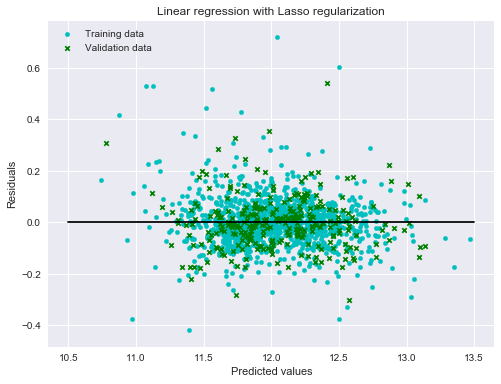

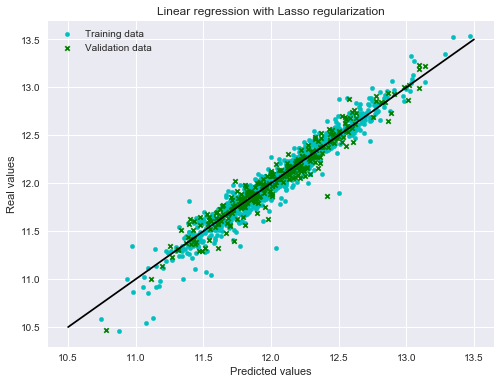

In [39]:
y_train_pred = lasso.predict(x_train)
y_test_pred = lasso.predict(x_test)

# Plot residence
plt.figure(figsize=(8,6))
plt.scatter(y_train_pred, y_train_pred - y_train, c = "c", marker = "o", s=20, label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "g", marker = "x", s=20, label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.plot([10.5,13.5],[0,0], color = "k")
plt.show()

# Plot predictions
plt.figure(figsize=(8,6))
plt.scatter(y_train_pred, y_train, c = "c", marker = "o", s=20, label = "Training data")
plt.scatter(y_test_pred, y_test, c = "g", marker = "x", s=20, label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "k")
plt.show()

### Elastic Net Model (L1 and L2 penalty)

Elastic Net is a compromise between Ridge and Lasso regression. It has a L1 penalty to generate sparsity and a L2 penalty to overcome some of the limitations of Lasso, such as the number of variables (Lasso can't select more features than it has observations, but it's not the case here anyway).

In [40]:
enet_cv = ElasticNetCV(alphas=np.arange(0.001,1,0.002), l1_ratio=(0.01,0.99,0.005)).fit(x_train, y_train)
alpha = enet_cv.alpha_
l1_ratio = enet_cv.l1_ratio_
print("Best alpha :", alpha)
print("Best L1 ratio :", l1_ratio)

Best alpha : 0.005
Best L1 ratio : 0.99


In [41]:
# # Try out the best L1 ratio first
# enet = ElasticNetCV(alphas=[0.001,0.005,0.01,0.05,0.1, 1, 10], l1_ratio=new_l1_ratios).fit(x_train, y_train)
# l1_ratio = enet.l1_ratio_
# print("Best L1 ratio :", l1_ratio)

# # Try out the best alpha based on the fixed best l1 ratio 
# enet = ElasticNetCV(alphas=new_alphas, l1_ratio=l1_ratio).fit(x_train, y_train)
# alpha = enet.alpha_
# l1_ratio = enet.l1_ratio_
# print("Best alpha :", alpha)
# print("Best L1 ratio :", l1_ratio)

In [42]:
enet = ElasticNet(alpha=0.005,l1_ratio=0.99).fit(x_train,y_train)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(enet).mean(),cv_rmse_train(enet).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(enet).mean(),cv_rmse_test(enet).std()))

RMSE (Training data): 0.1153 +/- 0.0130
RMSE (Validation data): 0.1246 +/- 0.0061


Lasso model: 95 features are picked and 323 features are dropped


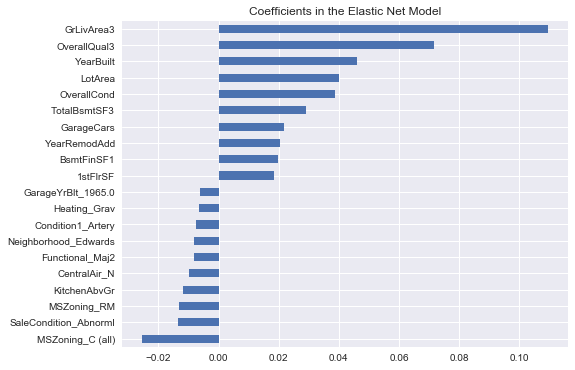

In [43]:
# Plot important coefficients
coefs = pd.Series(enet.coef_,index=all_data.columns)
print("Lasso model: " + str(sum(coefs != 0))+" features are picked and " + str(sum(coefs == 0))+" features are dropped")
imp_coefs = pd.concat([coefs.sort_values().head(10),coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Elastic Net Model")

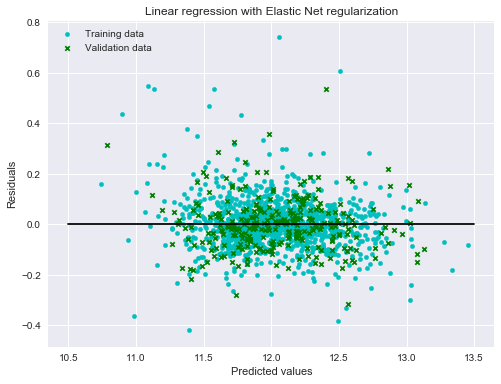

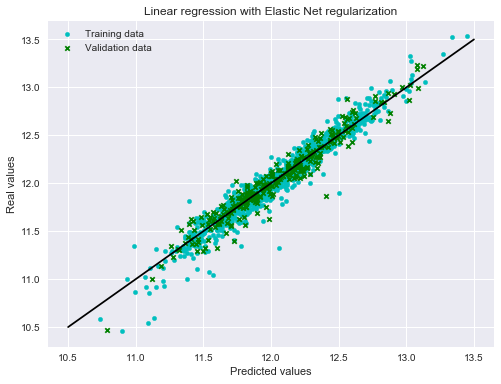

In [44]:
y_train_pred = enet.predict(x_train)
y_test_pred = enet.predict(x_test)

# Plot residence
plt.figure(figsize=(8,6))
plt.scatter(y_train_pred, y_train_pred - y_train, c = "c", marker = "o", s=20, label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "g", marker = "x", s=20, label = "Validation data")
plt.title("Linear regression with Elastic Net regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.plot([10.5,13.5],[0,0], color = "k")
plt.show()

# Plot predictions
plt.figure(figsize=(8,6))
plt.scatter(y_train_pred, y_train, c = "c", marker = "o", s=20, label = "Training data")
plt.scatter(y_test_pred, y_test, c = "g", marker = "x", s=20, label = "Validation data")
plt.title("Linear regression with Elastic Net regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "k")
plt.show()

## Random Forest

In [42]:
rf1=RandomForestRegressor(min_samples_split = 500,min_samples_leaf=50,max_features = 'sqrt',n_jobs=-1,oob_score=True,random_state=0)

In [43]:
# param_grid = {'n_estimators':np.arange(50,301,50),
#               'max_depth':np.arange(2,6,1)}
# rfgrid = GridSearchCV(estimator=rf1,param_grid=param_grid,cv=5,scoring="neg_mean_squared_error")
# rfgrid.fit(x_train,y_train)
# print(rfgrid.best_params_)
# print(np.sqrt(-rfgrid.best_score_))

In [44]:
# rf2=RandomForestRegressor(n_estimators=300,max_depth=3,
#                           n_jobs=-1,oob_score=True,random_state=0)
# param_grid = {'min_samples_split':np.arange(50,201,50),
#               'min_samples_leaf':np.arange(20,41,5),
#               'max_features':np.arange(20,36,5)}
# rfgrid = GridSearchCV(estimator=rf2,param_grid=param_grid,cv=5,scoring="neg_mean_squared_error")
# rfgrid.fit(x_train,y_train)
# print(rfgrid.best_params_)
# print(np.sqrt(-rfgrid.best_score_))

In [45]:
# Train a RF model using the best parameters found in grid search
rf = RandomForestRegressor(n_estimators= 1500, max_depth= 3, min_samples_split=50, min_samples_leaf =20,
                           max_features= 35, n_jobs=-1, oob_score=True, random_state=0)

In [55]:
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(rf).mean(),cv_rmse_train(rf).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(rf).mean(),cv_rmse_test(rf).std()))

KeyboardInterrupt: 

## Gradient Boosting

In [56]:
# Tune learning rate and n_estimators first;
gbst1 = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=200,min_samples_leaf=50, max_depth=8, 
                                 max_features='sqrt',subsample=0.8,random_state=0)
param_grid1 = {'n_estimators': np.arange(250,300,10)}
grid1 = GridSearchCV(estimator = gbst1,param_grid = param_grid1,cv=5, scoring="neg_mean_squared_error", n_jobs= -1)
grid1.fit(x_train,y_train)
print(grid1.best_params_)
print(np.sqrt(-grid1.best_score_)) 

I am gonna go with the 65 for now just to make sure all the following tests run fairly quickly. I will lower the learning rate at the end

In [48]:
# Tune tree-specific parameters in the order of max_depth, min_samples_spilt, min_samples_leaf, and max_features
gbst2 = GradientBoostingRegressor(n_estimators=280, learning_rate=0.1, min_samples_leaf=50, 
                                  max_features='sqrt',subsample=0.8,random_state=0)
param_grid2 = {'max_depth': np.arange(2,7,1),
               'min_samples_split': np.arange(300,351,20)}
grid2 = GridSearchCV(estimator = gbst2,param_grid = param_grid2,cv=5, scoring="neg_mean_squared_error", n_jobs= -1)
grid2.fit(x_train,y_train)
print(grid2.best_params_)
print(np.sqrt(-grid2.best_score_)) 

{'min_samples_split': 340, 'max_depth': 5}
0.131782594957


In [49]:
# Now tune min_samples_leaf and max_features
gbst3 = GradientBoostingRegressor(n_estimators=280, learning_rate=0.1, max_depth=5,min_samples_split=340,subsample=0.8,random_state=0)
param_grid3 = {'max_features': np.arange(25,36,5),
               'min_samples_leaf': np.arange(10,31,5)}
grid3 = GridSearchCV(estimator = gbst3,param_grid = param_grid3,cv=5, scoring="neg_mean_squared_error", n_jobs= -1)
grid3.fit(x_train,y_train)
print(grid3.best_params_)
print(np.sqrt(-grid3.best_score_)) 

{'max_features': 30, 'min_samples_leaf': 20}
0.123447861143


In [50]:
# Next tune subsample
gbst4 = GradientBoostingRegressor(n_estimators=280, learning_rate=0.1, max_depth=5,min_samples_split=340,
                                  min_samples_leaf=20, max_features=30,random_state=0)
param_grid4 = {'subsample': np.arange(0.5,1.0,0.05)}
grid4 = GridSearchCV(estimator = gbst4,param_grid = param_grid4,cv=5, scoring="neg_mean_squared_error", n_jobs= -1)
grid4.fit(x_train,y_train)
print(grid4.best_params_)
print(np.sqrt(-grid4.best_score_)) 

{'subsample': 0.85000000000000031}
0.123296106324


In [51]:
# Finally try to tune learning rate and n_estimators proportionally
gbst5 = GradientBoostingRegressor(n_estimators=280, learning_rate=0.1, max_depth=5,min_samples_split=340,
                                  min_samples_leaf=20, max_features=30,subsample=0.85, random_state=0)
gbst5.fit(x_train,y_train)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(gbst5).mean(),cv_rmse_train(gbst5).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(gbst5).mean(),cv_rmse_test(gbst5).std()))

RMSE (Training data): 0.1223 +/- 0.0153
RMSE (Validation data): 0.4101 +/- 0.0474


In [52]:
# Finally try to tune learning rate and n_estimators proportionally
gbst6 = GradientBoostingRegressor(n_estimators=560, learning_rate=0.05, max_depth=5,min_samples_split=340,
                                  min_samples_leaf=20, max_features=30,subsample=0.85, random_state=0)
gbst6.fit(x_train,y_train)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(gbst6).mean(),cv_rmse_train(gbst6).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(gbst6).mean(),cv_rmse_test(gbst6).std()))

RMSE (Training data): 0.1213 +/- 0.0147
RMSE (Validation data): 0.4099 +/- 0.0474


In [53]:
# Finally try to tune learning rate and n_estimators proportionally
gbst7 = GradientBoostingRegressor(n_estimators=2800, learning_rate=0.01, max_depth=5,min_samples_split=340,
                                  min_samples_leaf=20, max_features=30,subsample=0.85, random_state=0)
gbst7.fit(x_train,y_train)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(gbst7).mean(),cv_rmse_train(gbst7).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(gbst7).mean(),cv_rmse_test(gbst7).std()))

KeyboardInterrupt: 

## XGBoost

In [30]:
xgb = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.05,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)
xgb.fit(x_train,y_train)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(xgb).mean(),cv_rmse_train(xgb).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(xgb).mean(),cv_rmse_test(xgb).std()))

RMSE (Training data): 0.1277 +/- 0.0132
RMSE (Validation data): 0.1339 +/- 0.0182


## Predict the test label

In [46]:
## Getting the final SalePrice estimation
lasso_model = lasso.fit(x_train,y_train)
# gbst_model = gbst7.fit(x_train,y_train)
# rf_model = rf.fit(x_train,y_train)
enet_model = enet.fit(x_train,y_train)
xgb_model = xgb.fit(x_train,y_train)
final_labels = 0.5*np.exp(xgb_model.predict(test_features)) + 0.5*np.exp(enet_model.predict(test_features))

## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': final_labels}).to_csv('2017_6_29.csv', index =False) 